In [1]:
import d2l
import numpy as np
import pandas as pd
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn

# Accessing and Reading Data Sets

In [2]:
train_data = pd.read_csv('../data/house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('../data/house-prices-advanced-regression-techniques/test.csv')

In [3]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [6]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [12]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features.shape

(2919, 79)

# Data Preprocessing

In [17]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / x.std())
all_features = all_features.fillna(0)

In [18]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 354)

In [19]:
n_train = train_data.shape[0]
train_features = nd.array(all_features[:n_train].values)
test_features = nd.array(all_features[n_train:].values)
train_labels = nd.array(train_data.SalePrice.values).reshape((-1, 1))

# Training

In [20]:
loss = gloss.L2Loss()

def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    return net

In [21]:
def log_rmse(net, features, labels):
    clipped_preds = nd.clip(net(features), 1, float('inf'))
    rmse = nd.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean())
    return rmse.asscalar()

In [23]:
def train(net, train_features, train_labels, test_features, test_labels, 
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features, train_labels), batch_size, shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': learning_rate, 'wd': weight_decay})
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

# k-Fold Cross-Validation

In [24]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0)
    return X_train, y_train, X_valid, y_valid

In [26]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                        range(1, num_epochs + 1), valid_ls, ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

# Model Selection

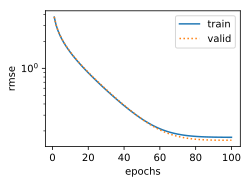

fold 0, train rmse 0.169680, valid rmse 0.157330
fold 1, train rmse 0.162072, valid rmse 0.188928
fold 2, train rmse 0.163737, valid rmse 0.168089
fold 3, train rmse 0.167676, valid rmse 0.154629
fold 4, train rmse 0.163034, valid rmse 0.182866
5-fold validation: avg train rmse: 0.165240, avg valid rmse: 0.170369


In [27]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f' % (k, train_l, valid_l))

# Predict and Submit

In [28]:
def train_and_pred(train_features, test_features, train_labels, test_data, 
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).asnumpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('../data/house-prices-advanced-regression-techniques/submission.csv', index=False)

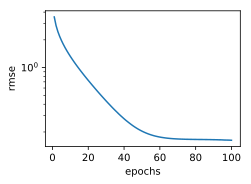

train rmse 0.162495


In [29]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)

# Problems

1. Submit your predictions for this tutorial to Kaggle. How good are your predictions?

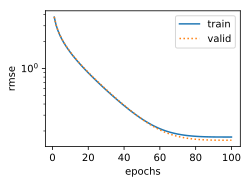

fold 0, train rmse 0.170957, valid rmse 0.157471
fold 1, train rmse 0.162862, valid rmse 0.193623
fold 2, train rmse 0.164509, valid rmse 0.169025
fold 3, train rmse 0.168890, valid rmse 0.154960
fold 4, train rmse 0.164145, valid rmse 0.183383
5-fold validation: avg train rmse: 0.166273, avg valid rmse: 0.171692


In [34]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0.01, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f' % (k, train_l, valid_l))

2. Can you improve your model by minimizing the log-price directly? What happens if you try to predict the log price rather than the price?

3. Is it always a good idea to replace missing values by their mean? Hint - can you construct a situation where the values are not missing at random?

4. Find a better representation to deal with missing values. Hint - What happens if you add an indicator variable?

5. Improve the score on Kaggle by tuning the hyperparameters through k-fold crossvalidation.

6. Improve the score by improving the model (layers, regularization, dropout).

7. What happens if we do not standardize the continuous numerical features like we have done in this section?